In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import hddm
from sys import platform
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
print(hddm.__version__)

0.6.0


In [3]:
if platform == 'linux':
    home = '/home/krista/'
elif platform == 'darwin': 
    home = '/Users/Krista/'

In [4]:
all_sim_data = hddm.load_csv(home + 'Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/probC_sim_learning_signals_processed.csv')
sim_plotting_data = all_sim_data
#use target choice as response 
#include correct target choice as stimulus 
all_sim_data = all_sim_data.rename(index=str, columns={"acc": "response"
                                                       })
all_sim_data = all_sim_data[['response', 'rt', 'cond', 'subj_idx', 'ideal_B', 'cpp']] 
# #use target-based belief in reward difference (b_t0 - b_t1)
all_sim_data = all_sim_data.rename(index=str, columns={'ideal_B': 'B'})
all_sim_data = all_sim_data[(all_sim_data.rt<0.6)]
all_sim_data.reset_index(drop=True, inplace=True)

In [5]:
all_sim_data.head()

,response,rt,cond,subj_idx,B,cpp
0,False,0.172,hc,0,-0.306135,0.019881
1,False,0.172,hc,0,-0.139394,0.018539
2,False,0.172,hc,0,-0.027685,0.268538
3,False,0.172,hc,0,-0.804363,0.035630
4,False,0.172,hc,0,0.064818,0.785155


In [6]:
#get all combinations of a,t,v,z 
from itertools import combinations

targets = ['a', 't', 'v', 'z']
param_pairs = list(combinations(targets, 2))
param_triples = list(combinations(targets, 3))

print(param_pairs)
print(len(param_pairs))

[('a', 't'), ('a', 'v'), ('a', 'z'), ('t', 'v'), ('t', 'z'), ('v', 'z')]
6


In [7]:
model_dict = {'a_t': param_pairs[0], 'a_v': param_pairs[1],
'a_z': param_pairs[2], 't_v': param_pairs[3], 
't_z': param_pairs[4], 'v_z': param_pairs[5], 'a': targets[0], 't': targets[1],
             'v': targets[2], 'z': targets[3]}

In [10]:
n_samples, n_burn = 3000, 500

In [9]:
# flat_m=hddm.HDDMStimCoding(all_sim_data, bias=True, stim_col='stimulus', p_outlier=0.05, split_param='v')
# flat_m.find_starting_values()
# flat_m.sample(n_samples, burn=n_burn)

In [11]:
a_v_m=hddm.HDDM(all_sim_data, depends_on={'a': 'cond', 'v': 'cond'}, bias=True)
a_v_m.find_starting_values()
a_v_m.sample(n_samples, burn=n_burn)

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3000 of 3000 complete in 968.6 sec

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [12]:
sum(np.isnan(all_sim_data.rt))

0

In [14]:
sim_plotting_data.loc[sim_plotting_data.acc == 1, 'gen_drift_flipped'] = abs(sim_plotting_data.loc[sim_plotting_data.acc == 1, 'gen_drift'])

In [15]:
sim_plotting_data.loc[sim_plotting_data.cond == 'lc', 'verbose_cond'] = 'low conflict'
sim_plotting_data.loc[sim_plotting_data.cond == 'hc', 'verbose_cond'] = 'high conflict'

sim_plotting_data.loc[sim_plotting_data.cond == 'lv', 'verbose_cond'] = 'low volatility'
sim_plotting_data.loc[sim_plotting_data.cond == 'hv', 'verbose_cond'] = 'high volatility'

NameError: name 'fitted_df' is not defined

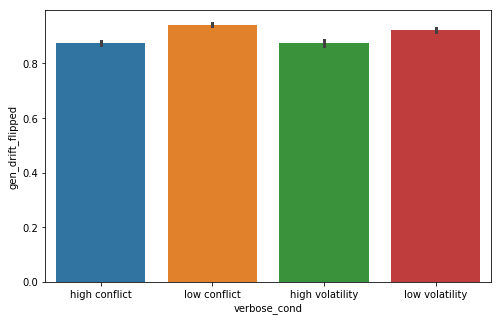

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x="verbose_cond",y="gen_drift_flipped", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated', )
sns.pointplot(x="condition",y="v", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black',)
# plt.ylim(0.5,.8)
plt.ylabel('Drift-rate')
plt.xlabel('Condition')
plt.legend(['fitted'])
plt.savefig('drift_sim_fit_gen.pdf')

In [ ]:
group_traces = a_v_m.get_group_traces()
a_hc, a_hv, a_lc, a_lv = group_traces.iloc[:,0], group_traces.iloc[:,1], group_traces.iloc[:,2], group_traces.iloc[:,3]

v_hc, v_hv, v_lc, v_lv = group_traces.iloc[:,7], group_traces.iloc[:,8], group_traces.iloc[:,9], group_traces.iloc[:,10]

In [ ]:
group_traces.mean()

In [ ]:
a = pd.concat([a_hc, a_hv, a_lc, a_lv]).values
v = pd.concat([v_hc, v_hv, v_lc, v_lv]).values
condition = np.repeat(['high conflict', 'high volatility', 'low conflict', 'low volatility'], len(a_lc))
d = {'a': a, 'v': v, 'condition': condition}
fitted_df = pd.DataFrame(data=d)

In [ ]:
plt.figure(figsize=(8,5))

sns.barplot(x="verbose_cond",y="gen_bound", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated' )
sns.pointplot(x="condition",y="a", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black')
plt.ylim(0.5,.8)
plt.legend(['fitted'])
plt.ylabel('Decision Threshold')
plt.xlabel('Condition')
plt.savefig('thresh_sim_fit_gen.pdf')

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(x="verbose_cond",y="gen_drift_flipped", data=sim_plotting_data, ci=95, n_boot=1000,units="ID", 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, label='simulated', )
sns.hist(x="condition",y="v", data=fitted_df, ci=95, n_boot=1000, 
           order=['high conflict', 'low conflict', 'high volatility', 'low volatility'], errwidth=3, linestyles='dotted', label='fitted', color='black',)
# plt.ylim(0.5,.8)
plt.ylabel('Drift-rate')
plt.xlabel('Condition')
plt.legend(['fitted'])
plt.savefig('drift_sim_fit_gen.pdf')